In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use(['science'])
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10

In [3]:
df_results = pd.read_csv('stability_results.csv')
df_results = df_results[~ df_results['seed'].isin([2])]

In [4]:
# we need to add the method of training to the dataframe
# by identifying whether "unrolled" or "ift" is in the opts field
df_results['method'] = df_results['opts'].apply(lambda x: 'unrolled' if 'unrolled' in x else 'ift')
# we need to get the f_thres_train field from the opts field
# basically except for f_thres_train = 18, the f_thres_train value is at the end of the output dir
# in the following fashion stability/${dir}_${f_thres}
def get_f_thres_train_from_output_dir(output_dir):
    dirs = output_dir.split('/')
    splits = dirs[1].split('_')
    if len(splits) == 2:
        f_thres_train = int(splits[-1])
    else:
        f_thres_train = 18
    return f_thres_train

def get_output_dir_from_opts(opts):
    # output dir has the following format stability/${dir}_${f_thres}
    opts = opts.split(',')
    for opt in opts:
        if 'stability' in opt:
            output_dir = opt
            break
    return output_dir
df_results['f_thres_train'] = df_results['opts'].apply(lambda x: get_f_thres_train_from_output_dir(get_output_dir_from_opts(x)))

In [5]:
# first we gather the ift results
# we are interested in the mean and the standard deviation of the top1 across all seeds
# for each f_thres_val
df_ift_raw = df_results[df_results['method'] == 'ift']
df_ift = df_ift_raw.groupby(['f_thres_val', 'f_thres_train']).agg({'top1': ['mean', 'std']})
df_ift = df_ift.reset_index()
df_ift.columns = ['f_thres_val', 'f_thres_train', 'top1_mean', 'top1_std']

# now we gather the unrolled results similarly
df_unrolled_raw = df_results[df_results['method'] == 'unrolled']
df_unrolled = df_unrolled_raw.groupby(['f_thres_val', 'f_thres_train']).agg({'top1': ['mean', 'std']})
df_unrolled = df_unrolled.reset_index()
df_unrolled.columns = ['f_thres_val', 'f_thres_train', 'top1_mean', 'top1_std']

In [6]:
df_unrolled_raw.query("f_thres_train == 18 & f_thres_val == 18")[["seed", "top1"]]

,seed,top1
992,9,85.389999
1014,7,83.389999
1019,0,84.400002
1021,3,84.579994
1023,5,84.829994
1024,6,84.930000
1030,8,85.970001
1032,4,84.900002
1054,1,84.250000


In [7]:
df_ift[df_ift["f_thres_train"] == 3]

,f_thres_val,f_thres_train,top1_mean,top1_std
0,3,3,62.502221,6.708203
4,5,3,62.848886,5.952651
8,6,3,62.091110,6.923206
13,9,3,60.841109,8.099276
17,10,3,61.034443,8.067020
21,11,3,60.731110,8.158751
26,15,3,60.439999,8.291367
30,16,3,60.503332,8.297659
34,18,3,60.313888,8.471240
38,20,3,60.288887,8.461565


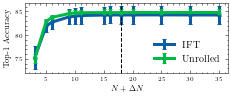

In [9]:
# we now plot the results as top1 function of f_thres_val (N)
# using lines with error bars (the error is the std) and dots
# we highlight the number of iterations used for training by drawing a dashed black vertical line at N = 18
# plt.figure(figsize=(5*0.7, 2.8*0.7))
# plt.tight_layout()
# plt.savefig('stability_results.pdf', dpi=300, bbox_inches='tight')

def plot_stability_single_n(ax, n=18, no_ift=False):
    if not no_ift:
        df_ift_ = df_ift[df_ift['f_thres_train'] == n]
        ax.errorbar(df_ift_['f_thres_val'], df_ift_['top1_mean'], yerr=df_ift_['top1_std'], label='IFT', marker='o', markersize=3, capsize=2, linewidth=3)
    df_unrolled_ = df_unrolled[df_unrolled['f_thres_train'] == n]
    ax.errorbar(df_unrolled_['f_thres_val'], df_unrolled_['top1_mean'], yerr=df_unrolled_['top1_std'], label='Unrolled', marker='o', markersize=3, capsize=2, linewidth=3)
    ax.axvline(x=n, color='k', linestyle='--')
    ax.set_xlabel(r'$N + \Delta N$')
    ax.set_ylabel('Top-1 Accuracy')
    ax.legend()

plot_stability_single_n(plt.figure(figsize=(5*0.7, 2.2*0.7)).add_subplot(111))
plt.tight_layout()
plt.savefig('stability_results.pdf', dpi=300, bbox_inches='tight')

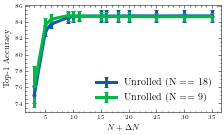

In [32]:
def plot_schematic(ax):
    df_unrolled_18 = df_unrolled[df_unrolled['f_thres_train'] == 18]
    ax.errorbar(df_unrolled_18['f_thres_val'], df_unrolled_18['top1_mean'], yerr=df_unrolled_18['top1_std'], label='Unrolled (N == 18)', marker='o', markersize=3, capsize=2, linewidth=3)
    df_unrolled_9 = df_unrolled[df_unrolled['f_thres_train'] == 9]
    ax.errorbar(df_unrolled_9['f_thres_val'], df_unrolled_9['top1_mean'], yerr=df_unrolled_9['top1_std'], label='Unrolled (N == 9)', marker='o', markersize=3, capsize=2, linewidth=3)
    ax.set_xlabel(r'$N + \Delta N$')
    ax.set_ylabel('Top-1 Accuracy')
    ax.legend()

plot_schematic(plt.figure(figsize=(5*0.7, 2.8*0.7)).add_subplot(111))

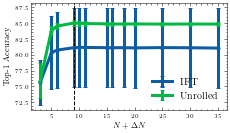

In [14]:
plot_stability_single_n(plt.figure(figsize=(5*0.7, 2.8*0.7)).add_subplot(111), n=9, no_ift=False)

/tmp/ipykernel_557933/1810185810.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ift_ref.sort_values(by="seed", inplace=True)
/tmp/ipykernel_557933/1810185810.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unrolled_ref.sort_values(by="seed", inplace=True)
/tmp/ipykernel_557933/1810185810.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ift_delta.sort_values(by="seed", inplace=True)
/tmp/ipykernel_557933/1810185810

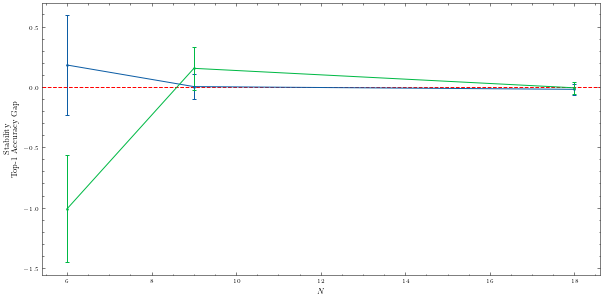

In [ ]:
def plot_stability_function_of_n(ax):
    # delta_ns = [-3, 2, 7]
    delta_ns = [7]
    linestyles = ['-', '--', ':']
    df_ift_ref = df_ift_raw[df_ift_raw['f_thres_train'] == df_ift_raw["f_thres_val"]]
    df_ift_ref.sort_values(by="seed", inplace=True)
    df_unrolled_ref = df_unrolled_raw[df_unrolled_raw['f_thres_train'] == df_unrolled_raw["f_thres_val"]]
    df_unrolled_ref.sort_values(by="seed", inplace=True)
    for delta_n, ls in zip(delta_ns, linestyles):
        # we are going to plot the top1 difference
        # between f_thres_val == f_thres_train + delta_n and f_thres_val == f_thres_train
        # function of f_thres_train
        # for each n_train (except for f_thres_train == 3 for delta_n = -3)
        ift_perf_gaps_mean = []
        ift_perf_gaps_std = []
        unrolled_perf_gaps_mean = []
        unrolled_perf_gaps_std = []
        # n_trains = sorted(df_results["f_thres_train"].unique()) if delta_n != -3 else [9, 18]
        n_trains = [6, 9, 18]
        for n_train in n_trains:
            df_ift_delta = df_ift_raw[(df_ift_raw['f_thres_val'] == n_train + delta_n) & (df_ift_raw['f_thres_train'] == n_train)]
            df_ift_delta.sort_values(by="seed", inplace=True)
            df_unrolled_delta = df_unrolled_raw[(df_unrolled_raw['f_thres_val'] == n_train + delta_n) & (df_unrolled_raw['f_thres_train'] == n_train)]
            df_unrolled_delta.sort_values(by="seed", inplace=True)
            df_ift_ref_ = df_ift_ref[df_ift_ref['f_thres_train'] == n_train]
            df_unrolled_ref_ = df_unrolled_ref[df_unrolled_ref['f_thres_train'] == n_train]
            df_ift_delta["perf_gap"] = df_ift_ref_["top1"].values - df_ift_delta["top1"].values
            df_unrolled_delta["perf_gap"] = df_unrolled_ref_["top1"].values - df_unrolled_delta["top1"].values
            ift_perf_gaps_mean.append(df_ift_delta["perf_gap"].mean())
            ift_perf_gaps_std.append(df_ift_delta["perf_gap"].std())
            unrolled_perf_gaps_mean.append(df_unrolled_delta["perf_gap"].mean())
            unrolled_perf_gaps_std.append(df_unrolled_delta["perf_gap"].std())
        ax.errorbar(n_trains, ift_perf_gaps_mean, yerr=ift_perf_gaps_std, label='IFT', marker='o', markersize=1.5, capsize=2, linewidth=1, linestyle=ls, color='C0')
        ax.errorbar(n_trains, unrolled_perf_gaps_mean, yerr=unrolled_perf_gaps_std, label='Unrolled', marker='o', markersize=1.5, capsize=2, linewidth=1, linestyle=ls, color='C1')
    ax.set_xlabel(r'$N$')
    ax.set_ylabel('Stability \nTop-1 Accuracy Gap')
    ax.axhline(y=0, color='r', linestyle='--')
            
plot_stability_function_of_n(plt.figure(figsize=(10, 5)).add_subplot(111))